## 1. Import Libraries

In [1]:
# Add package to path
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import numpy as np
import matplotlib.pyplot as plt
from galform_analysis.config import get_base_dir, get_snapshot_redshift
from galform_analysis.analysis.smf import compute_smf_avg_by_snapshot
from galform_analysis.analysis.hmf import compute_hmf_avg_by_snapshot

# Set up plotting
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## 2. Configure Base Directory and Snapshots

In [2]:
# The BASE_DIR is already configured in config.py
base_dir = get_base_dir()

# Define snapshots to analyze - using snapshots from our actual run
snapshots = ['iz82', 'iz100', 'iz120', 'iz155']

print(f"Base directory: {base_dir}")
print(f"Will analyze {len(snapshots)} snapshots:")
for snap in snapshots:
    z = get_snapshot_redshift(snap)
    print(f"  {snap}: z={z:.2f}" if z is not None else f"  {snap}: z=unknown")

Base directory: /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14
Will analyze 4 snapshots:
  iz82: z=6.01
  iz100: z=4.30
  iz120: z=3.05
  iz155: z=1.50


## 3. Compute Mass Functions for All Snapshots

We'll loop through each snapshot and compute both SMF and HMF efficiently.

**Performance Note:** Processing all snapshots can take several minutes depending on the number of completed subvolumes (~100-800 per snapshot). Each snapshot may take 1-3 minutes. For testing, you can reduce the snapshots list to just one or two snapshots first.

In [ ]:
import time

results = {}

for i, snapshot in enumerate(snapshots, 1):
    iz_path = base_dir / snapshot
    
    if not iz_path.exists():
        print(f"⚠ Warning: {iz_path} not found, skipping...")
        continue
    
    z = get_snapshot_redshift(snapshot)
    label = f"z={z:.2f}" if z is not None else snapshot
    print(f"\n📊 [{i}/{len(snapshots)}] Processing {snapshot} ({label})...")
    
    # Compute SMF and HMF separately
    start = time.time()
    smf = compute_smf_avg_by_snapshot(str(iz_path))
    hmf = compute_hmf_avg_by_snapshot(str(iz_path))
    elapsed = time.time() - start
    
    if smf is None and hmf is None:
        print(f"  ✗ No data for {snapshot}")
        continue
    
    results[snapshot] = {'smf': smf, 'hmf': hmf}
    
    if smf:
        print(f"  ✓ SMF: z={smf['z']:.2f}, used {smf['n_used']}/{smf['n_total']} subvolumes")
    if hmf:
        print(f"  ✓ HMF: z={hmf['z']:.2f}, used {hmf['n_used']}/{hmf['n_total']} subvolumes")
    
    print(f"  ⏱ Completed in {elapsed:.1f} seconds")

print(f"\n✓ Successfully processed {len(results)} snapshots")


📊 [1/4] Processing iz82 (z=6.01)...
  ✓ SMF: z=6.01, used 448/839 subvolumes
  ✓ HMF: z=6.01, used 448/839 subvolumes
  ⏱ Completed in 159.7 seconds

📊 [2/4] Processing iz100 (z=4.30)...
  ✓ SMF: z=4.30, used 337/839 subvolumes
  ✓ HMF: z=4.30, used 337/839 subvolumes
  ⏱ Completed in 206.3 seconds

📊 [3/4] Processing iz120 (z=3.05)...


## 4. Create Comparison Plots

Now let's create side-by-side plots of SMF and HMF evolution.

/tmp/ipykernel_3716834/3512901444.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=11, frameon=True)
/tmp/ipykernel_3716834/3512901444.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=11, frameon=True)


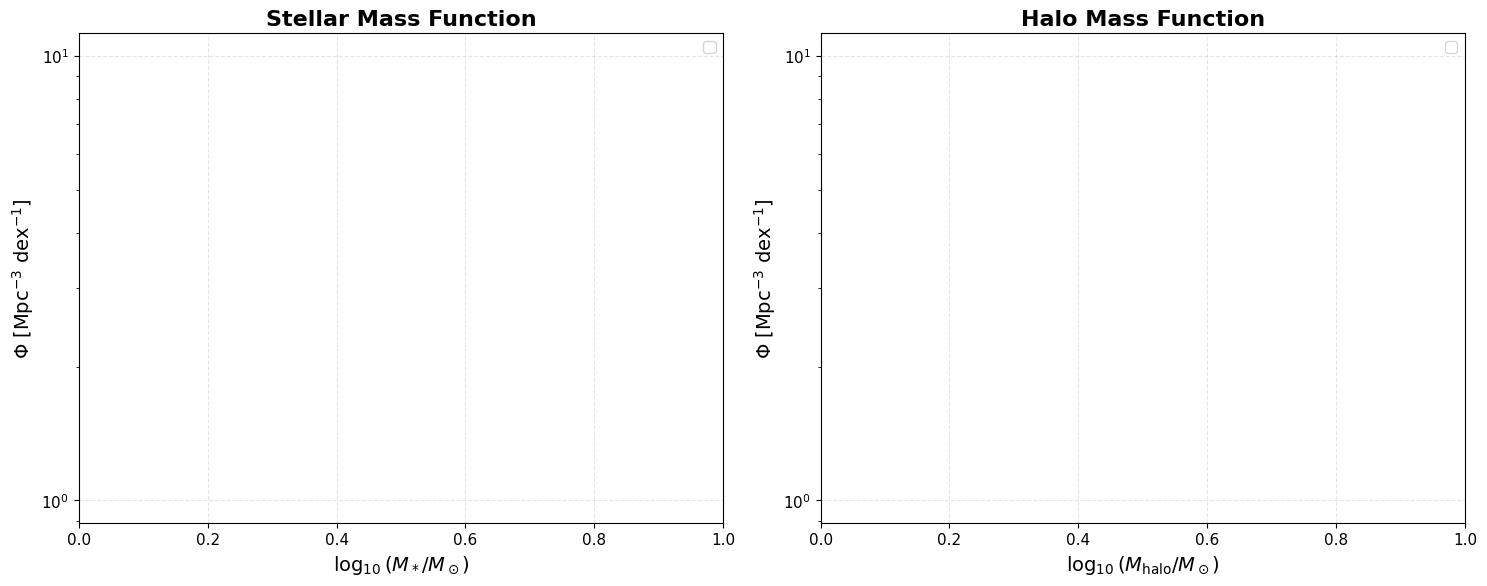

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Use a nice color scheme
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for (snapshot, data), color in zip(results.items(), colors):
    smf = data['smf']
    hmf = data['hmf']
    
    # Plot Stellar Mass Function
    if smf is not None:
        label = f"z={smf['z']:.1f}"
        ax1.plot(smf['centers'], smf['phi'], 'o-', color=color, 
                label=label, markersize=5, linewidth=2)
        
        # Add shaded error region
        ax1.fill_between(
            smf['centers'],
            smf['phi'] - smf['phi_std'],
            smf['phi'] + smf['phi_std'],
            alpha=0.2,
            color=color
        )
    
    # Plot Halo Mass Function
    if hmf is not None:
        label = f"z={hmf['z']:.1f}"
        ax2.plot(hmf['centers'], hmf['phi'], 'o-', color=color,
                label=label, markersize=5, linewidth=2)
        
        ax2.fill_between(
            hmf['centers'],
            hmf['phi'] - hmf['phi_std'],
            hmf['phi'] + hmf['phi_std'],
            alpha=0.2,
            color=color
        )

# Format Stellar Mass Function plot
ax1.set_yscale('log')
ax1.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=14)
ax1.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]', fontsize=14)
ax1.set_title('Stellar Mass Function', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, frameon=True)

# Format Halo Mass Function plot
ax2.set_yscale('log')
ax2.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$', fontsize=14)
ax2.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]', fontsize=14)
ax2.set_title('Halo Mass Function', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, frameon=True)

plt.tight_layout()
plt.show()

# Optionally save
# plt.savefig('mass_functions_comparison.png', dpi=150, bbox_inches='tight')

## 5. Summary Statistics

Let's examine how the number density evolves with redshift.

In [ ]:
# Move imports to top and fix undefined names
import os
import pandas as pd
import matplotlib.pyplot as plt

# Save mass function comparison plot and data to correct subfolders
plot_dir = 'examples/plots/smf'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, 'mass_functions_comparison.png'), dpi=150, bbox_inches='tight')

data_dir = 'examples/plots/_plots_data/smf'
os.makedirs(data_dir, exist_ok=True)
df = pd.DataFrame({
    'log(M)': smf['centers'],
    'SMF': smf['phi'],
    'HMF': hmf['phi']
})
df.to_csv(os.path.join(data_dir, 'mass_functions_comparison.csv'), index=False)


Summary Statistics:
Empty DataFrame
Columns: []
Index: []
